In [1]:
from models.mc import hybridMonteCarlo
from models.pso import PSO_Numpy, PSO_OpenCL
from models.utils import checkOpenCL
from models.utils import openCLEnv
import pyopencl as cl

import numpy as np
import matplotlib.pyplot as plt
import time

### fitness function: pso American option

In [2]:
def measureFitness(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype):
    cl_wall_time = []
    cl_copy_time = []
    np_wall_time = []
    fish_size = []

    print(f'{nPath} paths, {nPeriod} periods.\n')
    
    for exponent in range(min_exp, max_exp, step):  # This bit shift << operation does 'two to the exponent' (2^exponent)
        nFish = 1 << exponent            # 相当于 2 ** max_exp
        fish_size.append(nFish)
        print("exponent @ %s with nFish set to %d" %(exponent, nFish))

        mc = hybridMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
        # initialize data & memory objects
        pso = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32) * 100.0
        costs = np.empty(nFish, dtype=np.float32)
        pso_d = cl.Buffer(openCLEnv.context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=mc.pos_init)
        costs_d = cl.Buffer(openCLEnv.context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.ALLOC_HOST_PTR, size=costs.nbytes)
        
        # -------> run kernel
        ts = time.perf_counter() 
        mc.costPsoAmerOption_cl(pso_d, costs_d)
        openCLEnv.queue.finish()
        # evt_copy = cl.enqueue_copy(openCLEnv.queue, costs, costs_d)
        openCLEnv.queue.finish()
        
        walltime = (time.perf_counter() - ts)*1e3
        # copytime = (evt_copy.profile.end - evt_copy.profile.start)*1e-6

        # cl_copy_time.append(round(copytime, 4))
        cl_wall_time.append(round(walltime, 4))
        print('>>> GPU time: %s ms' %(cl_wall_time[-1]))
        
        # -------> run benchmark
        ts = time.perf_counter()
        fitFunc = np.vectorize(mc.costPsoAmerOption_np, signature='(n)->()')
        costs_valid = fitFunc(pso.T).astype(np.float32)
        numpytime = (time.perf_counter() - ts)*1e3
        np_wall_time.append(round(numpytime, 4))
        print('>>> CPU time: %s ms' %(np_wall_time[-1]))
        
        # cleanup device memory
        mc.cleanUp()
    
    return cl_copy_time, cl_wall_time, np_wall_time, fish_size

### searchGrid: particle move

In [3]:
def measureMoveParticle(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype):    
    cl_wall_time = []
    cl_copy_time = []
    np_wall_time = []
    fish_size = []
    
    print(f'PSO with {nPeriod} particle dimensions.\n')
    
    for exponent in range(min_exp, max_exp, step):  # This bit shift << operation does 'two to the exponent' (2^exponent)
        nFish = 1 << exponent            # 相当于 2 ** max_exp
        fish_size.append(nFish)
        print("exponent @ %s with nFish set to %d" %(exponent, nFish))
        
        mc = hybridMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
        pso_cl = PSO_OpenCL(mc, nFish, mc.costPsoAmerOption_cl)
        pso_np = PSO_Numpy(mc, nFish, mc.costPsoAmerOption_np)
        
        # ----> run kernel
        ts = time.perf_counter()
        pso_cl.searchGrid()
        openCLEnv.queue.finish()
        
        walltime = (time.perf_counter() - ts)*1e3
        cl_wall_time.append(round(walltime, 4))
        print('>>> GPU time: %s ms' %(cl_wall_time[-1]))
        
        # ----> run benchmark
        ts = time.perf_counter()
        pso_np.searchGrid()
        numpytime = (time.perf_counter() - ts)*1e3
        np_wall_time.append(round(numpytime, 4))
        print('>>> CPU time: %s ms' %(np_wall_time[-1]))

        # cleanup device memory
        pso_cl.cleanUp()
        mc.cleanUp()    

    return cl_copy_time, cl_wall_time, np_wall_time, fish_size


In [4]:
def plotResults(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, measureFunc):
    cl_copy_time, cl_wall_time, np_wall_time, fish_size =  measureFunc(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype)

    nfish = np.array(fish_size)
    x = np.arange(min_exp, max_exp, step, dtype=int)
    xtick = np.array([2**i for i in x])
    fig = plt.figure(figsize=(12,5))
    plt.plot(x, np.array(cl_wall_time), 'r-.', label='kernel_wall_time')
    plt.plot(x, np.array(np_wall_time), 'b-', label='numpy_time')
    # plt.plot(x, np.array(cl_copy_time), '*', label='copy_time')    

    print('fish size:', nfish)
    print('kernel wall time in ms:', cl_wall_time)
    print('numpy runtime in ms:', np_wall_time)
    # print('copy time in ms:', cl_copy_time)
    plt.legend(loc='best')
    plt.ylabel('milli-second (ms)')
    plt.xlabel('fish size (2^n) ranging from %d to %d'%( min(nfish), max(nfish) ) )
    plt.xticks(x, xtick)
    plt.title(f'PSO {measureFunc}: kernel (red) vs. numpy (blue) with {nPeriod} periods {nPath} paths')
    plt.show()

In [5]:
checkOpenCL()


OpenCL Platforms and Devices
Platform - Name: Apple
Platform - Vendor: Apple
Platform - Version: OpenCL 1.2 (Dec 13 2024 23:09:21)
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Apple M3 Max
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1000 Mhz
 Device - Compute Units: 40
 Device - Global Memory: 48 GB
 Device - Constant Memory: 1 GB
 Device - Local Memory: 32 KB (LOCAL)
 Device - Max Buffer/Image Size: 9 GB
 Device - Max Work Group Size: 256




In [6]:
# set fish exponent
min_exp, max_exp, step = 8, 17, 1

# set other parameters
S0, r, sigma, T, nPath, nPeriod, K, opttype = 100.0, 0.03, 0.3, 1.0, 20000, 200, 110.0, 'P', 

PSO with 200 particle dimensions.

exponent @ 8 with nFish set to 256
>>> GPU time: 6.4097 ms
>>> CPU time: 0.2352 ms
exponent @ 9 with nFish set to 512
>>> GPU time: 1.8642 ms
>>> CPU time: 0.1684 ms
exponent @ 10 with nFish set to 1024
>>> GPU time: 1.8455 ms
>>> CPU time: 0.454 ms
exponent @ 11 with nFish set to 2048
>>> GPU time: 1.9615 ms
>>> CPU time: 1.4113 ms
exponent @ 12 with nFish set to 4096
>>> GPU time: 2.2123 ms
>>> CPU time: 2.4833 ms
exponent @ 13 with nFish set to 8192
>>> GPU time: 3.0142 ms
>>> CPU time: 6.2692 ms
exponent @ 14 with nFish set to 16384
>>> GPU time: 10.3473 ms
>>> CPU time: 14.3699 ms
exponent @ 15 with nFish set to 32768
>>> GPU time: 13.0605 ms
>>> CPU time: 24.8814 ms
exponent @ 16 with nFish set to 65536
>>> GPU time: 29.2844 ms
>>> CPU time: 59.5508 ms
fish size: [  256   512  1024  2048  4096  8192 16384 32768 65536]
kernel wall time in ms: [6.4097, 1.8642, 1.8455, 1.9615, 2.2123, 3.0142, 10.3473, 13.0605, 29.2844]
numpy runtime in ms: [0.2352,

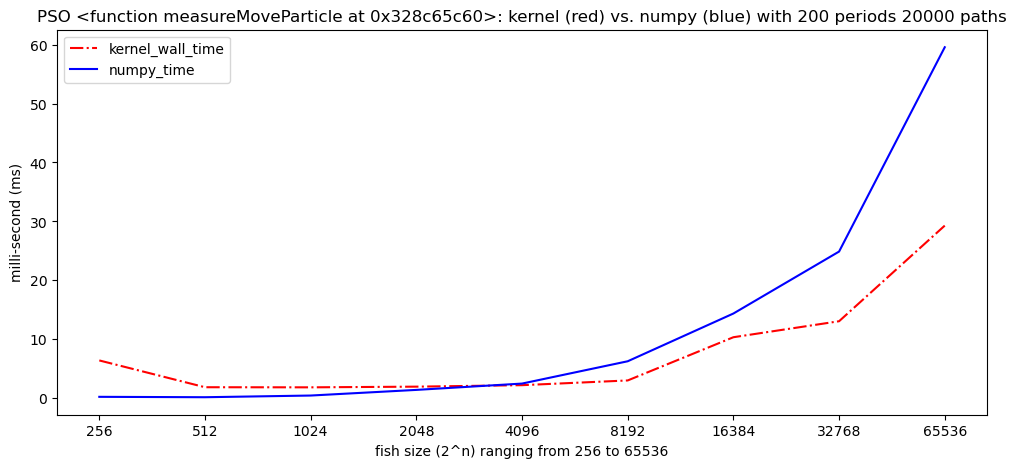

In [7]:
plotResults(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, measureMoveParticle)

20000 paths, 200 periods.

exponent @ 8 with nFish set to 256
>>> GPU time: 1006.8429 ms
>>> CPU time: 797.964 ms
exponent @ 9 with nFish set to 512
>>> GPU time: 1095.886 ms
>>> CPU time: 1597.8111 ms
exponent @ 10 with nFish set to 1024
>>> GPU time: 1005.7565 ms
>>> CPU time: 4360.9605 ms
exponent @ 11 with nFish set to 2048
>>> GPU time: 1013.2842 ms
>>> CPU time: 8691.3717 ms
exponent @ 12 with nFish set to 4096
>>> GPU time: 1138.3428 ms
>>> CPU time: 18134.585 ms
exponent @ 13 with nFish set to 8192
>>> GPU time: 1488.8551 ms
>>> CPU time: 35676.7208 ms
exponent @ 14 with nFish set to 16384
>>> GPU time: 1512.5036 ms
>>> CPU time: 72381.1769 ms
exponent @ 15 with nFish set to 32768
>>> GPU time: 2609.7372 ms
>>> CPU time: 326226.0828 ms
exponent @ 16 with nFish set to 65536
>>> GPU time: 5322.7889 ms
>>> CPU time: 851614.564 ms
fish size: [  256   512  1024  2048  4096  8192 16384 32768 65536]
kernel wall time in ms: [1006.8429, 1095.886, 1005.7565, 1013.2842, 1138.3428, 1488.85

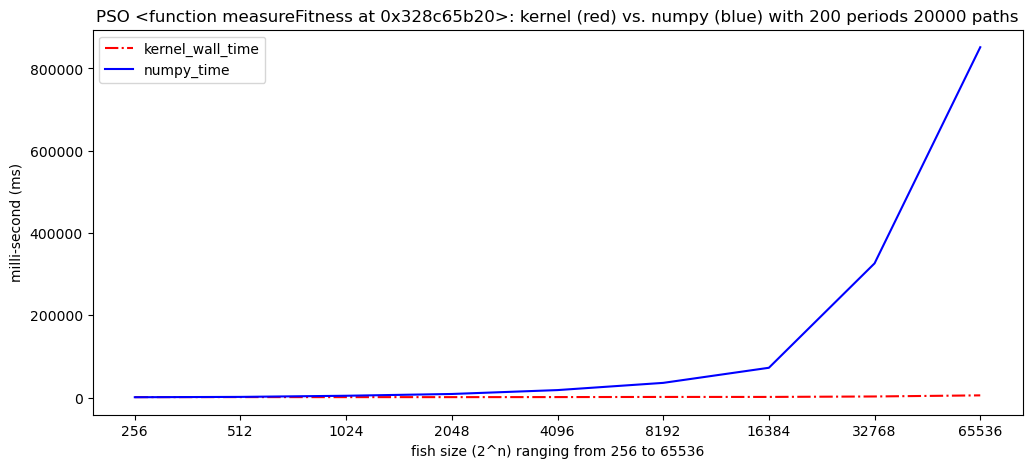

In [8]:
plotResults(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, measureFitness)